In [1]:
import numpy as np 
f = open("fci_gs.csv", 'rb').read()
data = f.decode().split('\n')

In [2]:
type(data)

list

In [3]:
data[0]

'date,ChicagoFCI_model,GSFCI_model,NA_model,MXmUS,SAmUS,CHIFCI,GSFCI,MXUSmSAUS,USDMXN_ret,USDZAR_ret,USDMXNMA_deviation,USDZARMA_deviation\r'

In [4]:
import os
import time
import warnings#tensorflowのワーニングの軽減
import numpy as np
from numpy import newaxis#配列変更
from keras.layers.core import Dense,Activation,Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential#時系列データ
import matplotlib.pyplot as plt


Using TensorFlow backend.
C:\Users\hirb7\Anaconda3\envs\env3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hirb7\Anaconda3\envs\env3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hirb7\Anaconda3\envs\env3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hirb7\Anaconda3\envs\env3.6\lib\sit

In [5]:
import pandas as pd
df = pd.read_csv("fci_gs.csv",index_col=0)
df.index=pd.to_datetime(df.index)

In [6]:
df.head(3)

,ChicagoFCI_model,GSFCI_model,NA_model,MXmUS,SAmUS,CHIFCI,GSFCI,MXUSmSAUS,USDMXN_ret,USDZAR_ret,USDMXNMA_deviation,USDZARMA_deviation
date,,,,,,,,,,,,
2005-04-01,0,0,1,0.049781,0.038687,0.004613,-0.04,1.941,-0.010257,0.006126,0.174600,0.317125
2005-04-08,1,0,0,0.006909,0.004341,0.008387,0.01,1.965,-0.004551,-0.016373,0.034975,0.258625
2005-04-15,0,0,1,0.046506,-0.032836,0.011422,0.15,2.385,-0.002807,0.020031,-0.033225,0.059925


In [7]:
df =np.array(df)

In [8]:
np.shape(df)

(763, 12)

In [9]:
# x_train = df.iloc[:500,3:]
# y_train = df.iloc[:500,:3]
# x_test = df.iloc[500:,3:]
# y_test = df.iloc[500:,:3]
# # reshape input to be [samples, time steps, features]
sequence_length = 50 + 1
result = []
for k in range(len(df) - sequence_length):#index:0～712
    result.append(df[k: k + sequence_length])
    

In [10]:
len(result)

712

In [11]:
result = np.array(result)

In [12]:
result[0][0]

array([ 0.        ,  0.        ,  1.        ,  0.04978104,  0.03868725,
        0.004613  , -0.04      ,  1.941     , -0.01025705,  0.00612636,
        0.1746    ,  0.317125  ])

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

normalized_data = []
scaler = MinMaxScaler(feature_range=(-1, 1))
for window in result:#51個のデータのうちはじめの1つめを基準に標準化
    normalized = scaler.fit_transform(window[:,3:])
    normalized_window = np.concatenate([window[:,:3],normalized],axis=1)
    normalized_data.append(normalized_window)

In [27]:
np.shape(normalized_data)

(712, 51, 12)

In [42]:
normalized_data[0][0]

array([ 0.        ,  0.        ,  1.        ,  0.69834779,  0.75014129,
       -0.07450577, -0.02702703,  0.43863636, -0.54970121,  0.06558063,
        0.90404516,  0.60117   ])

In [29]:
result =np.array(normalized_data)
train = result[:500,:,:]
x_train = train[:,:-1,3:]
y_train = train[:,-1,:3]
x_test = result[500:,:-1,3:]
y_test = result[500:,-1,:3]

In [30]:
np.shape(y_train)

(500, 3)

In [31]:
np.shape(x_test)

(212, 50, 9)

In [32]:
def build_model(layers):
    """
    inputはlayers[0]ここでは50×1が入る
    1番目のLSTM層がlayers[1]
    2番目のLSTM層がlayers[2]
    出力層がlayers[3]でregressionが
    """
    model = Sequential()
    model.add(LSTM(input_shape=(layers[1], layers[0]),
                  output_dim=layers[1],
                  return_sequences=True))
    #Dropoutさせる比率
    model.add(Dropout(0.2))
    
    #2番目のLSTM層
    model.add(LSTM(layers[2],return_sequences=False))
    model.add(Dropout(0.2))
    
    #全結合層
    model.add(Dense(output_dim=layers[3]))
    model.add(Activation("linear"))#活性化関数　通常はsigmoid
    
    #modelに結果が格納
    start = time.time()
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    #model.compile(loss="mse",optimizer="rmsprop", metrics =['accuracy'])
    print("実行時間: ",time.time() - start)
    return model


In [33]:
model =build_model([9,50,18,3])

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\hirb7\Anaconda3\envs\env3.6\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 9), return_sequences=True, units=50)`
  # This is added back by InteractiveShellApp.init_path()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
実行時間:  0.04037642478942871


C:\Users\hirb7\Anaconda3\envs\env3.6\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=3)`


In [34]:
history=model.fit(x_train,y_train,batch_size=32,nb_epoch=100,validation_split=0.05)

Instructions for updating:
Use tf.cast instead.


C:\Users\hirb7\Anaconda3\envs\env3.6\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 475 samples, validate on 25 samples
Epoch 1/100
475/475 [==============================] - 2s 5ms/step - loss: 6.2187 - acc: 0.3684 - val_loss: 0.8861 - val_acc: 0.0400
Epoch 2/100
475/475 [==============================] - 1s 3ms/step - loss: 5.2348 - acc: 0.3537 - val_loss: 0.9418 - val_acc: 0.0800
Epoch 3/100
475/475 [==============================] - 1s 3ms/step - loss: 5.1676 - acc: 0.3789 - val_loss: 0.7683 - val_acc: 0.0400
Epoch 4/100
475/475 [==============================] - 1s 2ms/step - loss: 3.4516 - acc: 0.2989 - val_loss: 0.5922 - val_acc: 0.0400
Epoch 5/100
475/475 [==============================] - 1s 2ms/step - loss: 3.2432 - acc: 0.2105 - val_loss: 1.6233 - val_acc: 0.0400
Epoch 6/100
475/475 [==============================] - 1s 2ms/step - loss: 4.5963 - acc: 0.1789 - val_loss: 12.5419 - val_acc: 0.0400
Epoch 7/100
475/475 [==============================] - 1s 2ms/step - loss: 7.8452 - acc: 0.1874 - val_loss: 9.1823 - val_acc: 0.0800
Epoch 8/100
475/475 [==

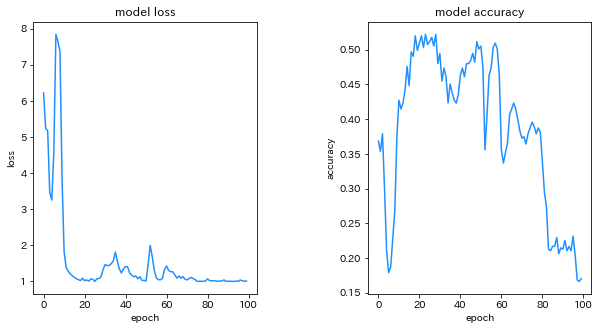

In [35]:
def plot_history_loss(fit):
    axL.plot(fit.history['loss'], label = "for training", color = 'dodgerblue')
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
import keras.backend as K

  
    
def plot_history_accuracy(fit):
    axR.plot(fit.history["acc"], label = "for training", color = 'dodgerblue')
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')

fig, (axL, axR) = plt.subplots(ncols = 2, figsize = (10,5))
plt.subplots_adjust(wspace = 0.5)
plot_history_loss(history)
plot_history_accuracy(history)
fig.savefig("loss_and_accuracy_LSTM.png", format = 'png', dpi = 300)

In [36]:
predicted = model.predict(x_test)
#predicted = np.reshape(predicted, (predicted.size,))

In [43]:
print(np.shape(predicted))
(np.shape(y_test))

(212, 3)


(212, 3)

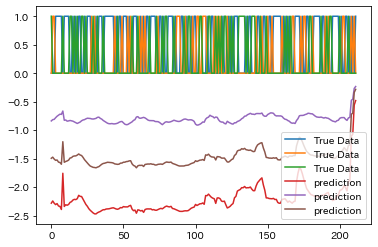

In [38]:
fig = plt.figure(facecolor="white")
ax =fig.add_subplot(1,1,1)#figの配置
ax.plot(y_test, label="True Data")
ax.plot(predicted, label="prediction")
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix

predict_classes = model.predict_classes(x_test)
true_classes = np.argmax(y_test, 1)
cmx = confusion_matrix(true_classes, predict_classes)
print(cmx)

[[  0 112   0]
 [  0  43   0]
 [  0  57   0]]


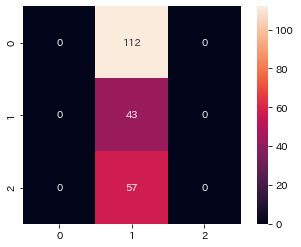

In [40]:
import seaborn as sns
sns.heatmap(cmx, annot=True, fmt='g', square=True)
plt.show()

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

print(classification_report(true_classes, predict_classes))

# from sklearn.metrics import f1_score
# print(f1_score(y_test, predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.20      1.00      0.34        43
           2       0.00      0.00      0.00        57

    accuracy                           0.20       212
   macro avg       0.07      0.33      0.11       212
weighted avg       0.04      0.20      0.07       212



C:\Users\hirb7\Anaconda3\envs\env3.6\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
